In [1]:
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import os
import copy
import unicodedata
import string
import re
import random
import io
import json
from io import open

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib import cm
%matplotlib inline
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode - o

from sentence_transformers import SentenceTransformer
lang_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

import vima_bench
from vima_bench import PARTITION_TO_SPECS

pybullet build time: Sep 21 2023 11:56:10


[INFO] 17 tasks loaded


In [2]:
# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)
                
# helper mlp init function
def mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod=None):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

class Flatten(nn.Module):
    def forward(self, x):
        return x.reshape(x.size(0), -1)

# CNN policy
class GCBCPolicy(nn.Module):
    def __init__(
        self, action_dim, hidden_size, output_mod=None):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4), nn.ReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,3,36,72)=>(b_size,32,8,17)
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32,8,17)=>(b_size,64,3,7)
            nn.Conv2d(64, 32, kernel_size=3, stride=1), nn.LeakyReLU(inplace=True), nn.BatchNorm2d(32), Flatten(), #(b_size,64,3,7)=>(b_size,32,1,5)=>(b_size,32*1*5)
            nn.Linear(32*1*5, hidden_size)#, nn.LeakyReLU(inplace=True), nn.BatchNorm1d(32), #(b_size,32*1*5)=>(b_size,action_dim)
        )
        self.policy = mlp(hidden_size+384, action_dim, hidden_dim=100, hidden_depth=1)
        self.apply(weight_init)

    def forward(self, state, goal):
        state = state/255.0 # process image + switch channels
        state = state.permute(0,3,1,2)
        state_embed = self.cnn(state)
        
        gc_embed = torch.cat([state_embed, goal], dim=1)
        action = self.policy(gc_embed)
        return action

class BCPolicy(nn.Module):
    def __init__(
        self, action_dim, hidden_size, output_mod=None):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4), nn.ReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,3,36,72)=>(b_size,32,8,17)
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32,8,17)=>(b_size,64,3,7)
            nn.Conv2d(64, 32, kernel_size=3, stride=1), nn.LeakyReLU(inplace=True), nn.BatchNorm2d(32), Flatten(), #(b_size,64,3,7)=>(b_size,32,1,5)=>(b_size,32*1*5)
            nn.Linear(32*1*5, action_dim)#, nn.LeakyReLU(inplace=True), nn.BatchNorm1d(32), #(b_size,32*1*5)=>(b_size,action_dim)
        )
        self.apply(weight_init)

    def forward(self, state):
        state = state/255.0 # process image + switch channels
        state = state.permute(0,3,1,2)
        action = self.cnn(state)
        return action

In [3]:
def flatten_act(action):
    return np.concatenate(list(action.values())).ravel()

# reconstructs actions for simulator
def reconstruct_act(action):
    reconst_action = {}
    reconst_action['pose0_position'] = np.array(action[0:2])
    reconst_action['pose0_rotation'] = np.array(action[2:6])
    reconst_action['pose1_position'] = np.array(action[6:8])
    reconst_action['pose1_rotation'] = np.array(action[8:12])
    reconst_action = {
        k: np.clip(v, env.action_space[k].low, env.action_space[k].high)
        for k, v in reconst_action.items()
    }
    return reconst_action

def process_obs(obs):
    obs = np.rollaxis(obs,0,3)
    cv2.imwrite('temp.jpg', obs)
    img = cv2.imread('temp.jpg')
    processed_obs = cv2.resize(img, dsize=(72, 36), interpolation=cv2.INTER_CUBIC)
    return processed_obs

def process_segm(segm, phi_hat, env_obj_info):
    # searches if obj + properties are in phi_hat, replaces with mask
    for obj in env_obj_info:
        if env_obj_info[obj]['obj_name'] in phi_hat.keys():
            if env_obj_info[obj]['texture_name'] in phi_hat[env_obj_info[obj]['obj_name']]:
                segm[segm == obj] = 255
    segm[segm < 255] = 0
    # reshape + resize
    segm = cv2.merge((segm,segm,segm))
    segm = cv2.resize(segm, dsize=(72, 36), interpolation=cv2.INTER_LINEAR_EXACT)
    return segm

def remove_obj(segm, obs, remove_obj):
    #if remove_obj == 'arm':
    #    segm = (segm == 2).astype(int)
    if remove_obj == 'base':
        segm = (segm == 5).astype(int)
    elif remove_obj == 'dragged':
        segm = (segm == 6).astype(int)
    elif remove_obj == 'distractor':
        segm = (segm == 7).astype(int)
    segm = np.atleast_3d(segm)
    
    for height in range(128):
        for width in range(256):
            if segm[height, width] == 1:
                obs[height, width] = 47
    return obs

def compare_actions(actions, gt_action):
    comparisons = []
    for action in actions:
        comparisons.append(np.linalg.norm(gt_action - action[[0,1,6,7]],ord=2))
    return comparisons

# generates random trajs within specified constraints
def gen_trajs(env, num_trajs, task_name, task_kwargs, goal, phi_hat):
    trajs = []
    task = env.task
    oracle_fn = task.oracle(env)
    for traj in tqdm(range(num_trajs)):
        traj = {'obs': [], 'mask_obs': [], 'acts': [], 'goals':[], 'meta': []}
        obs = env.reset()
        traj['meta'] = env.meta_info
        obj_type = env.meta_info['obj_id_to_info'][6]['obj_name']
        goal_embed = lang_model.encode(obj_type)
        for step in range(1):
            mask_obs = obs['segm']['top'] # extracts segm
            top_obs = obs['rgb']['top'] # extracts top down view only
            traj['obs'].append(process_obs(top_obs))
            traj['mask_obs'].append(process_segm(mask_obs, phi_hat, env.meta_info['obj_id_to_info']))
            traj['goals'].append(goal_embed)
            # prompt, prompt_assets = env.prompt, env.prompt_assets
            oracle_action = oracle_fn.act(obs)
            # clip action
            oracle_action = {
                k: np.clip(v, env.action_space[k].low, env.action_space[k].high)
                for k, v in oracle_action.items()
            }
            traj['acts'].append(flatten_act(oracle_action))
            obs, _, done, info = env.step(action=oracle_action, skip_oracle=False)
        traj['obs'] = np.array(traj['obs'])
        traj['mask_obs'] = np.array(traj['mask_obs'])
        traj['acts'] = np.array(traj['acts'])
        traj['goals'] = np.array(traj['goals'])
        traj['meta'] = np.array(traj['meta'])
        trajs.append(traj)
    return trajs

In [4]:
lang_goal = 'bring me the bowl'
lang_embed = lang_model.encode(lang_goal)
phi_hat = {
    'block': ['red'],
}

task_name = 'visual_manipulation'
#task_kwargs = {'num_dragged_obj': 1,
#               'num_distractors_obj': 0,
#               'possible_angles_of_rotation': 120,
#               'possible_dragged_obj': ['pan'],
#               'possible_dragged_obj_texture': ['blue']}
task_kwargs = { 
    'num_dragged_obj': 1,
    'num_base_obj': 1,
    'num_other_obj': 1,
    'dragged_obj_loc': [1],
    'base_obj_loc': [4],
    'third_obj_loc' : [3],
    'fourth_obj_loc' : [2],
    'possible_dragged_obj': ['tomato'],
    'possible_dragged_obj_texture': ['green'],
    'possible_base_obj': ['square'],
    'possible_base_obj_texture': ['blue'],
    'possible_third_obj': ['tomato'],
    'possible_third_obj_texture': ['red'],
    'possible_fourth_obj': ['tomato'],
    'possible_fourth_obj_texture': ['green']
}
#record_gui=True, display_debug_window=True, hide_arm_rgb=False
env = vima_bench.make(task_name=task_name,task_kwargs=task_kwargs,hide_arm_rgb=False)

num_trajs = 5
trajs = gen_trajs(env=env, num_trajs=num_trajs, task_name=task_name, task_kwargs=task_kwargs, goal=lang_embed, phi_hat=phi_hat)
pickle.dump(trajs, open('trajs.pkl', 'wb'))
env.close()

100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]


In [5]:
num_tasks = len(trajs)

act_size = trajs[0]['acts'][0].shape[0]
hidden_size = 100

#policy = GCBCPolicy(act_size, hidden_size)
policy = BCPolicy(act_size, hidden_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy.to(device)

BCPolicy(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten()
    (10): Linear(in_features=160, out_features=12, bias=True)
  )
)

[1,     1] loss: 1.61062396
[2,     1] loss: 1.61367834
[3,     1] loss: 1.59098458
[4,     1] loss: 1.57353747
[5,     1] loss: 1.58623242
[6,     1] loss: 1.57087910
[7,     1] loss: 1.56873393
[8,     1] loss: 1.53686786
[9,     1] loss: 1.54649568
[10,     1] loss: 1.52772713
[11,     1] loss: 1.51567709
[12,     1] loss: 1.49084020
[13,     1] loss: 1.49254262
[14,     1] loss: 1.48371851
[15,     1] loss: 1.45930648
[16,     1] loss: 1.43876958
[17,     1] loss: 1.43767571
[18,     1] loss: 1.41496778
[19,     1] loss: 1.39762664
[20,     1] loss: 1.37828636
[21,     1] loss: 1.36582005
[22,     1] loss: 1.35114646
[23,     1] loss: 1.31358314
[24,     1] loss: 1.27988565
[25,     1] loss: 1.27069664
[26,     1] loss: 1.24625564
[27,     1] loss: 1.21412241
[28,     1] loss: 1.19604373
[29,     1] loss: 1.16423512
[30,     1] loss: 1.13926744
[31,     1] loss: 1.10864818
[32,     1] loss: 1.08577025
[33,     1] loss: 1.05032098
[34,     1] loss: 1.03050351
[35,     1] loss: 0.997

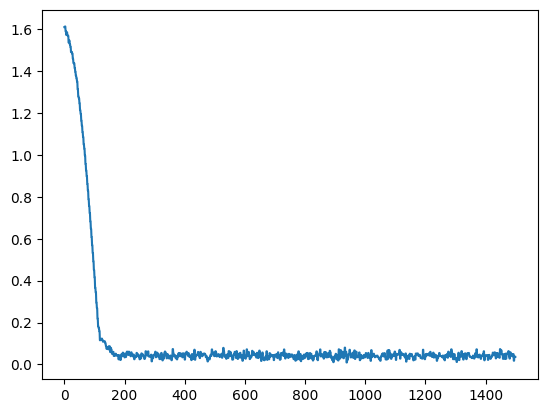

In [6]:
mask = True
num_epochs = 750
batch_size = 5

criterion = nn.MSELoss()
optimizer = optim.Adam(list(policy.parameters()), lr=0.001)

losses = []

idxs = np.array(range(len(trajs)))

num_batches = len(idxs) // batch_size
# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    np.random.shuffle(idxs)
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()

        t_idx = np.random.randint(len(trajs), size=(batch_size,)) # Indices of traj
        t_idx_pertraj = np.random.randint(1, size=(batch_size,)) # Indices of timesteps in traj
        if mask:
            t_states = np.concatenate([trajs[c_idx]['mask_obs'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])

        else:
            t_states = np.concatenate([trajs[c_idx]['obs'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        t_goals = np.concatenate([trajs[c_idx]['goals'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        t_actions = np.concatenate([trajs[c_idx]['acts'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
   
        t_states = torch.Tensor(t_states).float().to(device)
        t_goals = torch.Tensor(t_goals).float().to(device)
        t_actions = torch.Tensor(t_actions).float().to(device)
        
        #a_preds = policy(t_states, t_goals)
        a_preds = policy(t_states)
        loss = torch.mean(torch.linalg.norm(a_preds - t_actions, dim=-1)) # supervised learning loss
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0
        losses.append(loss.item())

torch.save(policy, 'policy_gcbc.pt')
print('Finished Training')
plt.plot(losses)

In [26]:
lang_goal = 'sweep the block while avoiding the line'
lang_embed = lang_model.encode(lang_goal)
phi_hat = {
    'block': ['red'],
}
mask = True

#task_name = 'sweep_without_touching'
#task_kwargs = {'constraint': True,
#               'dragged_obj_loc': [4],
#               'possible_base_obj': ['three-sided rectangle'],
#               'possible_base_obj_texture': ['blue'],
#               'possible_dragged_obj': ['small block'],
#               'possible_dragged_obj_texture': ['granite'],
#               'possible_constraint_obj': ['line'],
#               'possible_constraint_obj_texture': ['tiger']}
task_kwargs = { 
    'num_dragged_obj': 1,
    'num_base_obj': 1,
    'num_other_obj': 2,
    'dragged_obj_loc': [1],
    'base_obj_loc': [4],
    'third_obj_loc' : [3],
    'fourth_obj_loc' : [2],
    'possible_dragged_obj': ['tomato'],
    'possible_dragged_obj_texture': ['red'],
    'possible_base_obj': ['square'],
    'possible_base_obj_texture': ['blue'],
    'possible_third_obj': ['tomato'],
    'possible_third_obj_texture': ['green'],
    'possible_fourth_obj': ['star'],
    'possible_fourth_obj_texture': ['yellow']
}
record_cfg = {'save_video': True,
     'save_video_path': './rollouts_gcbc/',
     'view': 'front',
     'fps': 18,
     'video_height': 320,
     'video_width': 368}
# record_gui=True, display_debug_window=True, hide_arm_rgb=False
env = vima_bench.make(task_name=task_name,task_kwargs=task_kwargs,hide_arm_rgb=False,display_debug_window=False,record_cfg=record_cfg)

In [ ]:
oracle = True

if oracle:
    task = env.task
    oracle_fn = task.oracle(env)
else:
    policy = torch.load('policy_gcbc.pt')
    policy.eval()

num_test_trajs = 1
video = True

plt.xlim(-0.5, 0.5)
plt.ylim(0.3, 0.7)

successes = []

rollouts = {'actions': [], 'action_starts': [],'action_ends': [], 'true_starts': [], 'true_ends': []}

for i in tqdm(range(num_test_trajs)):
    os.makedirs('rollouts_gcbc/' + str(i), exist_ok=True)
    obs = env.reset()
    obj_type = env.meta_info['obj_id_to_info'][6]['obj_name']
    goal_embed = lang_model.encode(obj_type)
    
    if video:
        video_name = str(i)
        env.start_rec(video_name)
    for step in range(1):
        if oracle:
            oracle_action = oracle_fn.act(obs)
            # clip action
            oracle_action = {
                k: np.clip(v, env.action_space[k].low, env.action_space[k].high)
                for k, v in oracle_action.items()
            }
            obs, _, done, info = env.step(action=oracle_action, skip_oracle=False)
        
        else:
            # constructs s_hat from phi_hat
            segm = obs['segm']['top']
            s_hat = process_segm(segm, phi_hat, env.meta_info['obj_id_to_info'])
            im = Image.fromarray(s_hat.astype(np.uint8))
            im.save('rollouts_gcbc/'+str(i)+"/"+str(step)+'_mask.jpg')
            
            # saves rgb image as well
            top_obs = obs['rgb']['top']
            top_obs = process_obs(top_obs)
            im = Image.fromarray(top_obs)
            im.save('rollouts_gcbc/'+str(i)+"/"+str(step)+'.jpg')
            
            # uses either s_hat or true obs
            state = s_hat if mask else top_obs
            
            state = torch.Tensor(state[None]).to(device)
            goal = torch.Tensor(lang_embed[None]).to(device)
            #action = policy(state,goal).cpu().detach().numpy()[0]
            action = policy(state).cpu().detach().numpy()[0]
            
            rollouts['actions'].append(action)
            rollouts['action_starts'].append(action[0:2].copy())
            rollouts['action_ends'].append(action[6:8].copy())
            obs, _, done, info = env.step(action=reconstruct_act(action), skip_oracle=False)
        
        if done:
            successes.append(1)
        else:
            successes.append(0)
            
    if video:
        env.end_rec()
    
    # constructs s_hat from phi_hat
    segm = obs['segm']['top']
    s_hat = process_segm(segm, phi_hat, env.meta_info['obj_id_to_info'])
    im = Image.fromarray(s_hat.astype(np.uint8))
    im.save('rollouts_gcbc/'+str(i)+"/"+str(step+1)+'_mask.jpg')
            
    # saves rgb image as well
    top_obs = obs['rgb']['top']
    top_obs = process_obs(top_obs)
    im = Image.fromarray(top_obs)
    im.save('rollouts_gcbc/'+str(i)+"/"+str(step+1)+'.jpg')

env.close()
print(sum(successes)/len(successes))

  0%|                                                                         | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
